<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 


__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2> 1.2 Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

<h2>1.3 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

In [ ]:
!pip install nltk
!pip install bs4
!pip install fuzzywuzzy
!pip install distance
import nltk
nltk.download('all')

     |████████████████████████████████| 180 kB 5.0 MB/s 
  Created wheel for distance: filename=Distance-0.1.3-py3-none-any.whl size=16275 sha256=7b46a21e88d0986302cb150e9fcef37c6c1b7ffd50d3cd227763bb6bc5bdb351
  Stored in directory: /root/.cache/pip/wheels/b2/10/1b/96fca621a1be378e2fe104cfb0d160bb6cdf3d04a3d35266cc
Successfully built distance
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpor

True

In [ ]:
# All imports here
import re
import os
import distance

import numpy as np
import pandas as pd
import seaborn as sns

from fuzzywuzzy import fuzz
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
import nltk
import spacy

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
# Define the Constants, file paths and global objects

train_data_path = '/content/drive/MyDrive/Quora_Question_Pair_Similarity/data/train.csv'
test_data_path = '/content/drive/MyDrive/Quora_Question_Pair_Similarity/data/test.csv'
processed_train_data_path = '/content/drive/MyDrive/Quora_Question_Pair_Similarity/data/processed_train_data.csv'

LAPLACE_SMOOTHING = 0.0001 
STOP_WORDS = stopwords.words("english")
PORTER_STEMMER = PorterStemmer()
GLOVE_VECTORS = spacy.load('en_core_web_sm')

word_expansions = {
    ",000,000":"m",
    ",000" : "k",
    "′" : "'",
    "won't" : "will not",
    "cannot" : "can not",
    "can't" : "can not",
    "n't" : " not",
    "what's" : "what is",
    "it's" : "it is",
    "'ve" : " have",
    "i'm" : "i am",
    "'re" : " are",
    "he's" : "he is",
    "she's" : "she is",
    "'s" : " own",
    "%" : " percent ",
    "₹" : " rupee ",
    "$" : " dollar ",
    "€" : " euro ",
    "'ll" : " will"
    }

In [ ]:
def get_data(path):
  """
  Helper method to read CSV data from the given file path
  """
  data_frame = pd.read_csv(path)
  return data_frame

def unique_words_in_questions(row):
  """
  Helper to get a set of unique words in Q1 and Q2
  """
  w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
  w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
  return w1,w2

def number_of_common_words(row):
  """
  Helper to get count of common words in Q1 and Q2
  """
  w1,w2 = unique_words_in_questions(row)
  return 1.0 * len(w1 & w2)

def total_number_of_words(row):
  """
  Helper to get count of total words in Q1 and Q2
  """
  w1,w2 = unique_words_in_questions(row)
  return 1.0 * (len(w1) + len(w2))

def preprocess_text(text):
  """
  Helper method to expand contractions and stem words
  """
  for key,value in word_expansions.items():
    text = text.replace(key,value)
  text = BeautifulSoup(PORTER_STEMMER.stem(text)).get_text()
  return text  

def get_token_features(question1, question2):
  """
  Helper method to construct Token based features
  """
  # Initialize empty list
  token_features = [0.0]*10
  if len(question1) == 0 or len(question2) == 0:
      return token_features
  
  # Split Q1 and Q2 to get tokens
  q1_tokens = question1.split()
  q2_tokens = question2.split()

  # Get words in Q1 and Q2 (excluding stop words)
  q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
  q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
  
  # Get Stop Words in Q1 and Q2
  q1_stop_words = set([word for word in q1_tokens if word in STOP_WORDS])
  q2_stop_words = set([word for word in q2_tokens if word in STOP_WORDS])
  
  # Get Common Word, Stop Word and Token Counts
  common_word_count = len(q1_words.intersection(q2_words))
  common_stop_count = len(q1_stop_words.intersection(q2_stop_words))
  common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
  
  # Minimum Common Word Count ratio
  token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + LAPLACE_SMOOTHING)
  # Maximum Common Word Count ratio
  token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + LAPLACE_SMOOTHING)
  # Minimum Stop Word Count ratio
  token_features[2] = common_stop_count / (min(len(q1_stop_words), len(q2_stop_words)) + LAPLACE_SMOOTHING)
  # Maximum Stop Word Count ratio
  token_features[3] = common_stop_count / (max(len(q1_stop_words), len(q2_stop_words)) + LAPLACE_SMOOTHING)
  # Mimimum Token Count ratio
  token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + LAPLACE_SMOOTHING)
  # Maximum Token Count ratio
  token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + LAPLACE_SMOOTHING)
  
  # Last word of both questions is same or not?
  token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
  # First word of both questions is same or not
  token_features[7] = int(q1_tokens[0] == q2_tokens[0])
  # Absolute Length difference between Q1 and Q2
  token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
  # Average Token Length of both Questions
  token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
  
  return token_features

def get_longest_substr_ratio(a, b):
  """
  Helper method to find Longest Common Substring Ratio
  """
  strs = list(distance.lcsubstrings(a, b))
  if len(strs) == 0:
      return 0
  else:
      return len(strs[0]) / (min(len(a), len(b)) + 1)

def get_features(df):
  """
  Helper method that does feature engineering on the input data
  """
  # Question 1 length
  df['q1_length'] = df['question1'].str.len()
  # Question 2 length
  df['q2_length'] = df['question2'].str.len()
  # Number of Words in Question 1
  df['n_words_q1'] = df['question1'].apply(lambda row : len(row.split(" ")))
  # Number of Words in Question 1
  df['n_words_q2'] = df['question2'].apply(lambda row : len(row.split(" ")))
  # Common words in Q1 and Q2
  df['common_word_count'] = df.apply(number_of_common_words, axis=1)
  # Total number of words in Q1 and Q2
  df['total_words'] = df.apply(total_number_of_words, axis=1)
  # Word Share = Common Words/ Total Words
  df['word_share'] = df['common_word_count']/df['total_words']
  # Preprocess Q1 and Q2 (Expand contractions, Stemming)
  df['question1'] = df['question1'].apply(preprocess_text)
  df['question2'] = df['question2'].apply(preprocess_text)
  # Get Token based features using the helper
  token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
  df["cwc_min"] = list(map(lambda x: x[0], token_features))
  df["cwc_max"] = list(map(lambda x: x[1], token_features))
  df["csc_min"] = list(map(lambda x: x[2], token_features))
  df["csc_max"] = list(map(lambda x: x[3], token_features))
  df["ctc_min"] = list(map(lambda x: x[4], token_features))
  df["ctc_max"] = list(map(lambda x: x[5], token_features))
  df["is_last_word_equal"]  = list(map(lambda x: x[6], token_features))
  df["is_first_word_equal"] = list(map(lambda x: x[7], token_features))
  df["abs_len_diff"] = list(map(lambda x: x[8], token_features))
  df["mean_length"] = list(map(lambda x: x[9], token_features))

  # Get Similarity based features using FuzzyWuzzy library
  df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
  df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
  df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
  df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
  df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
  return df

In [ ]:
# Load the train data 
train_data = get_data(train_data_path)
print("Train Data shape:", train_data.shape)

Train Data shape: (404290, 6)


In [ ]:
# Load the test data
test_data = get_data(test_data_path)
print("Test Data shape:", test_data.shape)

Test Data shape: (2345796, 3)


In [ ]:
# Basic statistics for train data
print(train_data.describe())

                  id           qid1           qid2   is_duplicate
count  404290.000000  404290.000000  404290.000000  404290.000000
mean   202144.500000  217243.942418  220955.655337       0.369198
std    116708.614502  157751.700002  159903.182629       0.482588
min         0.000000       1.000000       2.000000       0.000000
25%    101072.250000   74437.500000   74727.000000       0.000000
50%    202144.500000  192182.000000  197052.000000       0.000000
75%    303216.750000  346573.500000  354692.500000       1.000000
max    404289.000000  537932.000000  537933.000000       1.000000


In [ ]:
# Remove rows from train data with NaN values
train_data = train_data.drop(index = train_data[(train_data.isnull().any(axis=1))].index)
print("Shape after removing NaN values:", train_data.shape)

Shape after removing NaN values: (404287, 6)


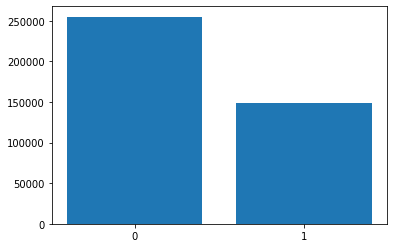

In [ ]:
# Plot the histogram for Class Label count
class_labels = dict(Counter(train_data['is_duplicate']))
plt.bar(class_labels.keys(), list(class_labels.values()), tick_label = list(class_labels.keys()))
plt.show()

In [ ]:
def plot_util(df, column1, column2):
  """
  Helper method for plotting pdf for features
  """
  plt.figure(figsize=(12, 8))
  plt.subplot(1,2,1)
  
  sns.violinplot(x = column1, y = column2, data = df[0:])

  plt.subplot(1,2,2)
  sns.distplot(df[df[column1] == 1.0][column2][0:] , label = "1", color = 'red')
  sns.distplot(df[df[column1] == 0.0][column2][0:] , label = "0" , color = 'blue')

  plt.show()

In [ ]:
def get_tf_idf_scores(train_data):
  """
  Helper method to get Tf- IDF scores map for the train data
  """
  # Combine words from Q1 and Q2
  questions = list(train_data['question1']) + list(train_data['question2'])

  tfidf = TfidfVectorizer(lowercase=False, )
  tfidf.fit_transform(questions)

  # Tf-idf map(key:word, value:score)  
  word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))
  
  return word2tfidf

In [ ]:
def questions_to_vector(df,column_name,tf_idf_map):
  # Convert questions to vectors
  question_vectors = []
  for question in tqdm(list(df[column_name])):
    # Get glove representation for each question using spacy library
    sentence = GLOVE_VECTORS(question)
    # Initialize mean_vector of size word's dimension
    mean_vector = np.zeros(len(sentence[0].vector))
    # Get weighted tf-idf for each question
    for word in sentence:
      tf_idf_score = tf_idf_map.get(str(word), 0.0)
      mean_vector = mean_vector + (word.vector * tf_idf_score)
    mean_vector = mean_vector/len(sentence)  
    question_vectors.append(mean_vector)
  # Convert to a data frame and merge to original df
  question_vector_features_df = pd.DataFrame(question_vectors, index = df.index)
  question_vector_features_df['id'] = df['id']
  df = df.merge(question_vector_features_df, on='id', how='left')
  return df

In [ ]:
# Perform feature engineering on the train data
train_data = get_features(train_data)
print(train_data.head(5))

/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


   id  qid1  qid2  ... token_set_ratio token_sort_ratio  longest_substr_ratio
0   0     1     2  ...             100               93              0.965517
1   1     3     4  ...              86               63              0.576923
2   2     5     6  ...              63               63              0.166667
3   3     7     8  ...              28               24              0.039216
4   4     9    10  ...              67               47              0.150000

[5 rows x 28 columns]


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


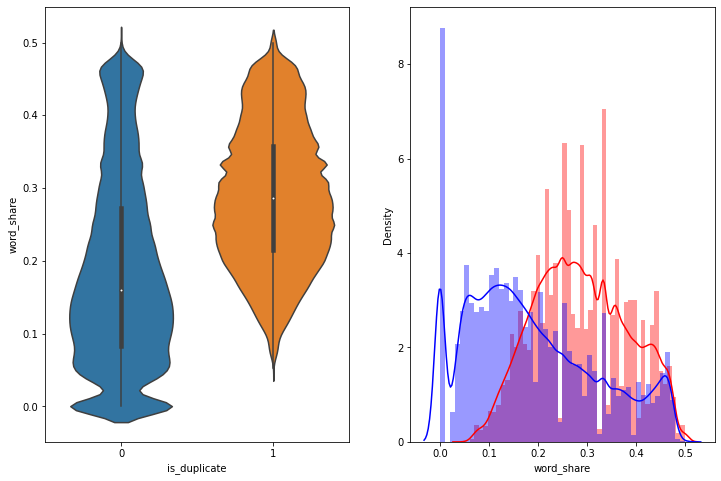

In [ ]:
# Plot the pdf for Word Share
plot_util(train_data,'is_duplicate','word_share')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


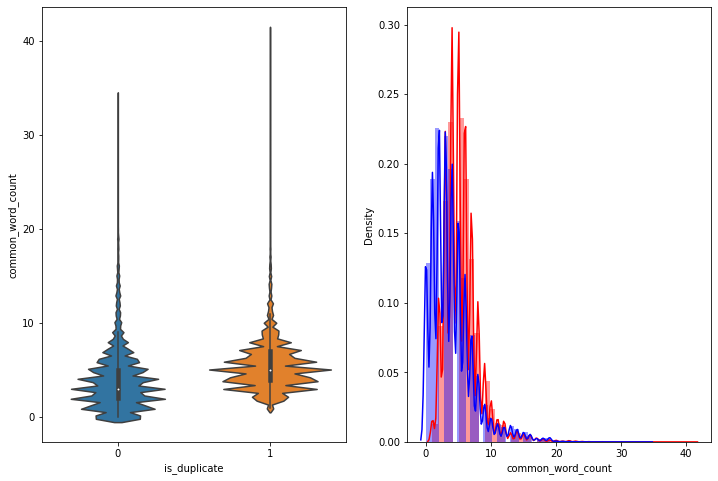

In [ ]:
# Plot the pdf for Common Word Count
plot_util(train_data,'is_duplicate','common_word_count')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


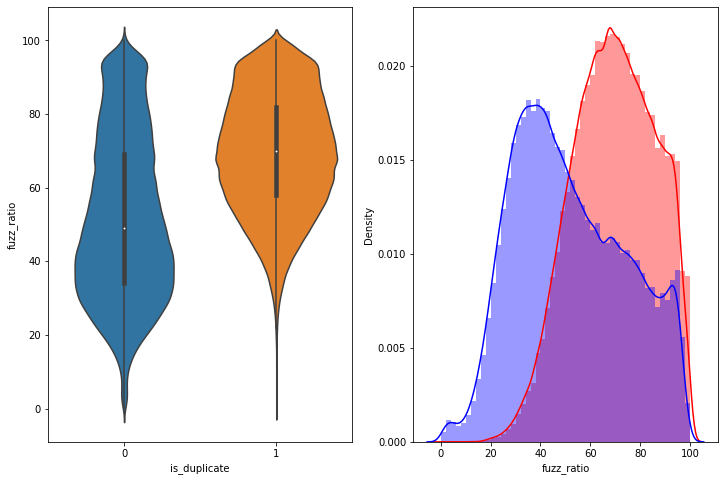

In [ ]:
# Plot the pdf for Fuzz ratio
plot_util(train_data, 'is_duplicate', 'fuzz_ratio')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


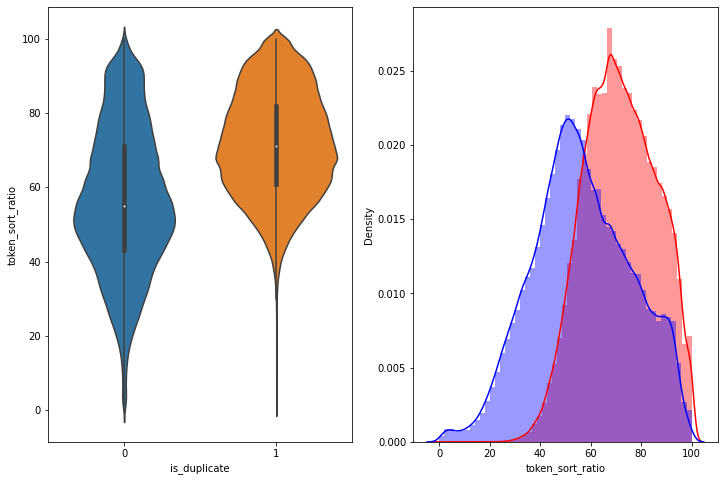

In [ ]:
# Plot the pdf for Token Sort ratio
plot_util(train_data, 'is_duplicate', 'token_sort_ratio')

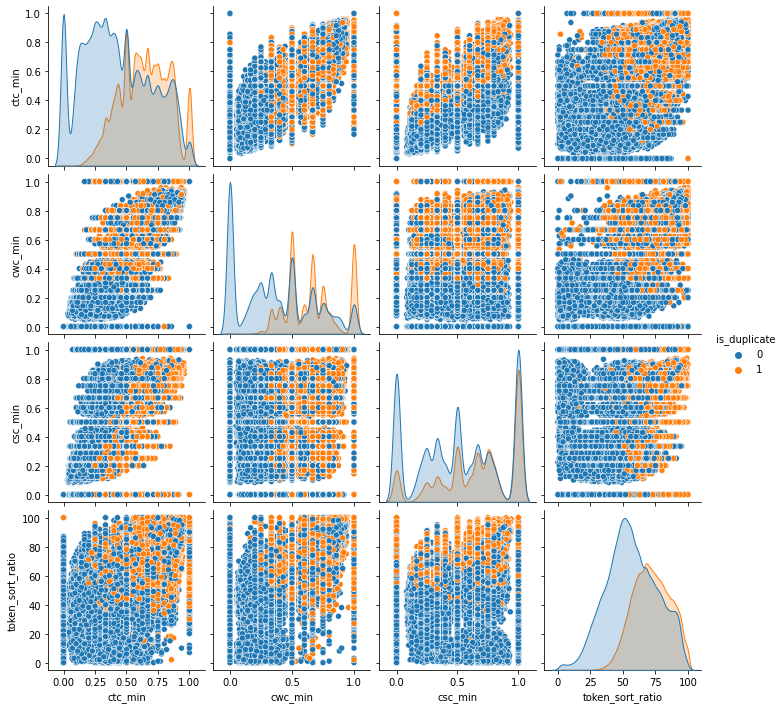

In [ ]:
# Pair plot for 'ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'
sns.pairplot(train_data[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

In [ ]:
# Get Tf idf map on train data set
tf_idf_map = get_tf_idf_scores(train_data)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# Convert Q1 and Q2 to weighted tf idf format
train_data = questions_to_vector(train_data,'question1',tf_idf_map)
train_data = questions_to_vector(train_data,'question2',tf_idf_map)

100%|██████████| 404287/404287 [1:13:36<00:00, 91.54it/s]


In [ ]:
# Write the processed data to CSV format
if not os.path.isfile(processed_train_data_path):
  train_data.to_csv(processed_train_data_path)

In [ ]:
train_data.head(5)

,id,qid1,qid2,question1,question2,is_duplicate,q1_length,q2_length,n_words_q1,n_words_q2,common_word_count,total_words,word_share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,is_last_word_equal,is_first_word_equal,abs_len_diff,mean_length,fuzz_ratio,fuzz_partial_ratio,token_set_ratio,token_sort_ratio,longest_substr_ratio,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,...,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,66,57,14,12,10.0,23.0,0.434783,0.799984,0.666656,0.999983,0.999983,0.833326,0.714281,0,1,2,13.0,93,98,100,93,0.965517,-0.720333,2.754333,-4.222322,1.932754,9.043366,8.197494,0.805366,3.720923,4.711040,15.379524,1.343128,-0.603313,...,8.887354,1.830261,-3.574513,8.600769,7.998979,-5.479509,6.607309,3.384856,-1.303888,-8.073140,5.304549,-3.494147,-4.316612,3.617608,-8.848644,1.061047,0.298321,-2.189647,-5.973593,6.093163,9.652551,-9.519052,1.362442,1.855714,2.834302,-6.482746,-4.676351,-0.031969,-4.363221,-3.367160,-5.453991,-3.158653,-2.642037,6.999320,-3.412467,-2.679790,-5.710365,7.867247,3.351740,-1.605795
1,1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0,51,88,8,13,4.0,20.0,0.200000,0.499988,0.222220,0.666644,0.499988,0.499994,0.307690,0,1,5,10.5,66,75,86,63,0.576923,-2.775033,-6.777093,-0.499547,1.646973,14.089853,-4.167413,2.390021,4.140972,4.630390,6.934117,1.061225,-1.391706,...,9.347099,4.787107,-3.688867,-1.227360,-3.584115,-4.688157,3.787538,-0.834316,4.070605,1.092263,2.306724,-1.675986,-1.721369,5.182110,-3.180714,4.988505,-0.145446,-0.154252,-3.668202,1.644254,4.144931,-4.571638,-1.714638,0.205619,-0.240756,-10.272331,-2.037930,2.324899,2.229488,2.993240,2.078682,-1.962114,-1.936102,0.717106,2.356621,7.060276,-3.225820,10.036602,3.315929,2.677703
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,73,59,14,10,4.0,24.0,0.166667,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0,1,4,12.0,43,47,63,63,0.166667,7.160725,0.407561,-1.607014,1.037635,3.425060,2.957842,1.908470,2.910349,6.961462,14.664533,-0.640958,-3.794078,...,2.401437,-5.423563,2.676597,3.083648,11.284867,-7.772189,-1.024058,-0.561322,-6.667777,-12.235910,3.926284,-4.059393,-2.075985,8.743520,1.722742,0.134613,3.381155,-1.745354,-0.242160,-2.126445,7.621891,-7.762352,-2.081456,-0.666103,-0.471314,0.490730,-3.600043,2.093803,0.543818,-6.722593,-1.068153,-4.415849,7.029934,1.737582,-7.295253,-15.440657,-6.955535,0.393453,-1.402100,4.833022
3,3,7,8,why am i mentally very lonely? how can i solve...,find the remainder when [math]23^{24}[/math] i...,0,50,65,11,9,0.0,19.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,2,10.0,9,10,28,24,0.039216,3.929508,-1.614899,0.724957,-6.814559,0.888359,-2.039403,4.090393,7.870204,2.040115,3.772932,-5.553511,-2.204998,...,2.236720,1.356889,2.061221,1.685249,2.832566,-6.277001,4.469772,-2.778295,-3.777050,-2.126844,3.259130,1.698495,0.800833,4.553124,1.606953,4.043043,4.039255,-2.766649,0.791367,-0.798523,1.854848,-5.084795,-1.711740,-0.443270,-2.506009,-2.044155,0.539693,5.493016,-2.193468,-3.389831,-1.339141,1.611777,2.864556,1.131903,0.073100,-3.783749,0.459920,-1.556160,-0.452557,-0.878433
4,4,9,10,"which one dissolve in water quikly sugar, salt...",which fish would survive in salt water?,0,76,39,13,7,2.0,20.0,0.100000,0.000000,0.000000,0.999950,0.666644,0.285710,0.153845,0,1,6,10.0,35,54,67,47,0.150000,5.470480,-2.830371,-5.206552,-3.205866,5.275935,-0.776089,2.778995,6.041529,10.460243,17.651430,2.471585,1.808608,...,7.184210,3.350058,-6.217545,17.299213,10.020420,-7.936012,6.410579,5.224147,6.618058,-3.775143,5.454022,-6.205514,-8.340063,6.816134,1.932465,-0.787116,-2.469743,-3.517213,-5.438979,8.664

In [ ]:
train_data.shape

(404287, 220)